# Traffic Sign Recognition Classifier



---
## Load Dataset and Import Packages

In [291]:
# Visualizations will be shown in the notebook.
%matplotlib inline

# Load pickled data
import pickle
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.io.parsers import read_csv



training_file = 'Dataset/train.p'
validation_file='Dataset/valid.p'
testing_file = 'Dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
sign_names = read_csv("signnames.csv").values[:, 1]
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---
## Dataset Summary & Exploration

In [292]:
# Number of training examples
n_train = X_train.shape[0]
# Number of validation examples
n_validation = X_valid.shape[0]
# Number of testing examples.
n_test = X_test.shape[0]
# What's the shape of an traffic sign image?
image_shape = X_train[0].shape
# Unique classes/labels there are in the dataset.
classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
n_classes = len(class_counts)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Histogram of class distrubtions across data set splits

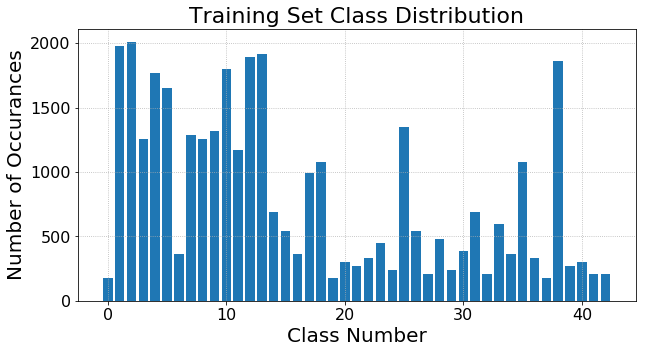

In [298]:
plt.figure(0, figsize = (10,5))
unique_train, counts_train = np.unique(y_train, return_counts = True)
plt.bar(unique_train, counts_train)

plt.title('Training Set Class Distribution', fontsize=22)
plt.xlabel('Class Number', fontsize=20)
plt.ylabel('Number of Occurances', fontsize=20)
plt.tick_params(labelsize=16)
plt.grid(linestyle=':')




### Visualise all Images Classes

0 . Class :  Speed limit (20km/h)


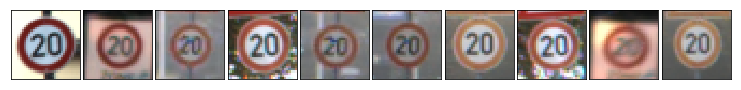

1 . Class :  Speed limit (30km/h)


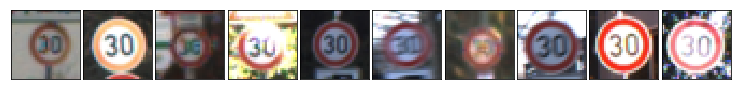

2 . Class :  Speed limit (50km/h)


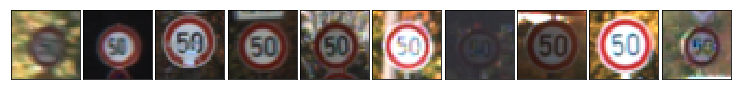

3 . Class :  Speed limit (60km/h)


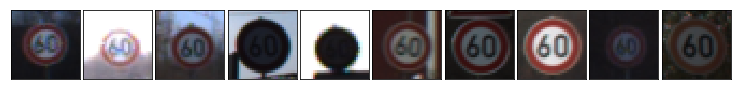

4 . Class :  Speed limit (70km/h)


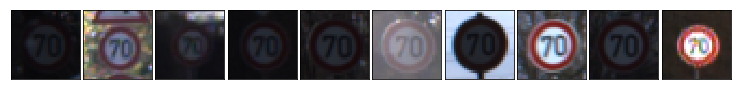

5 . Class :  Speed limit (80km/h)


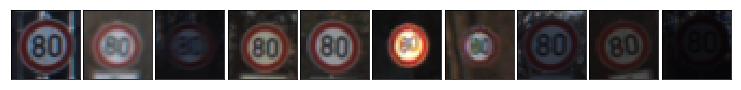

6 . Class :  End of speed limit (80km/h)


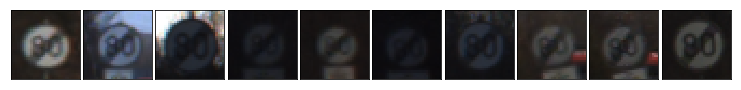

7 . Class :  Speed limit (100km/h)


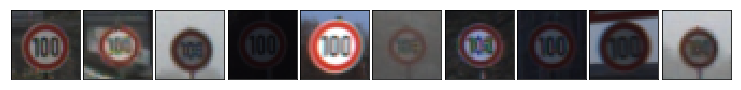

8 . Class :  Speed limit (120km/h)


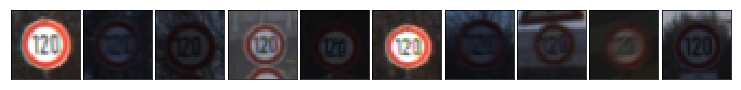

9 . Class :  No passing


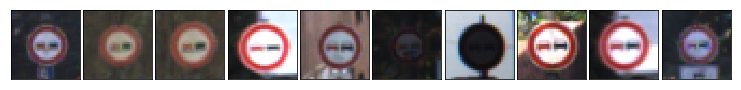

10 . Class :  No passing for vehicles over 3.5 metric tons


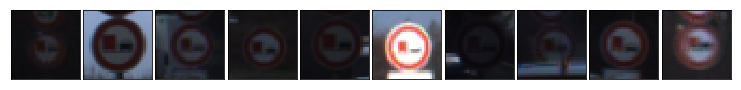

11 . Class :  Right-of-way at the next intersection


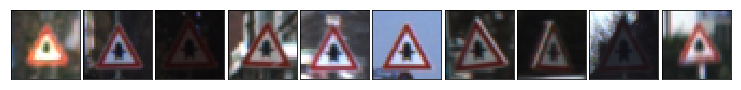

12 . Class :  Priority road


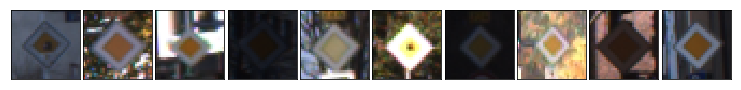

13 . Class :  Yield


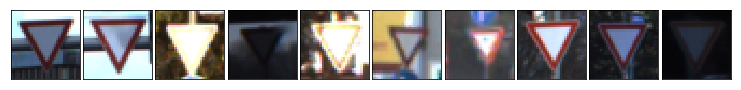

14 . Class :  Stop


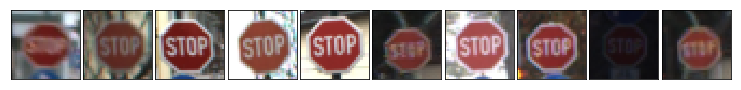

15 . Class :  No vehicles


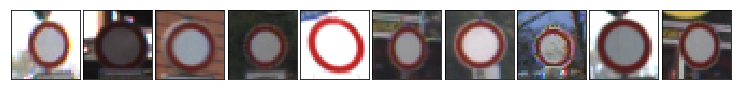

16 . Class :  Vehicles over 3.5 metric tons prohibited


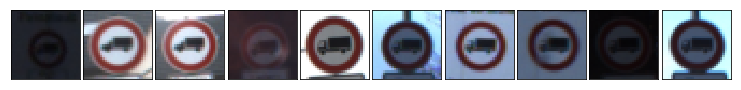

17 . Class :  No entry


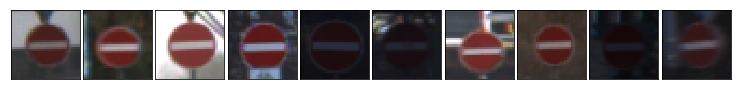

18 . Class :  General caution


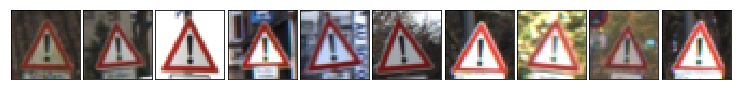

19 . Class :  Dangerous curve to the left


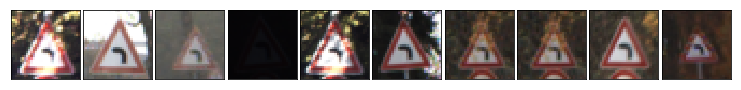

20 . Class :  Dangerous curve to the right


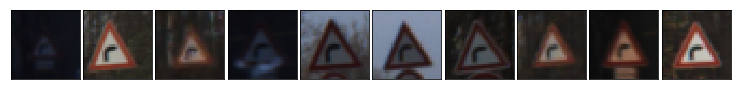

21 . Class :  Double curve


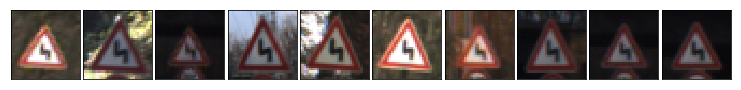

22 . Class :  Bumpy road


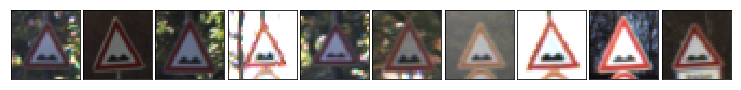

23 . Class :  Slippery road


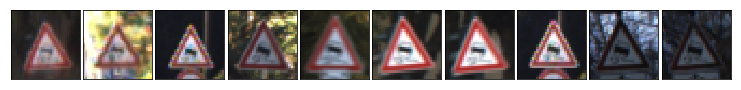

24 . Class :  Road narrows on the right


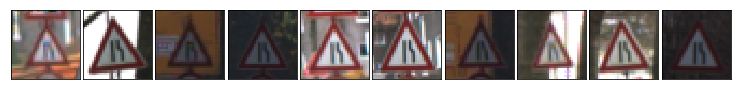

25 . Class :  Road work


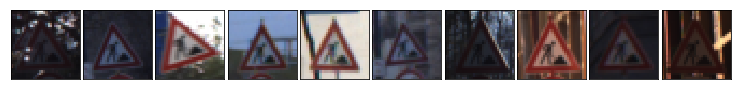

26 . Class :  Traffic signals


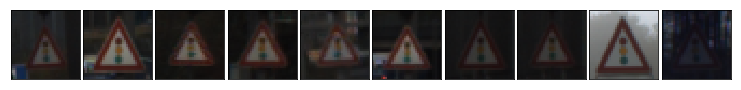

27 . Class :  Pedestrians


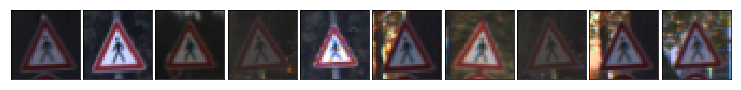

28 . Class :  Children crossing


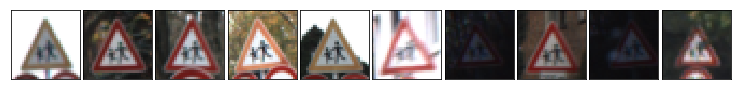

29 . Class :  Bicycles crossing


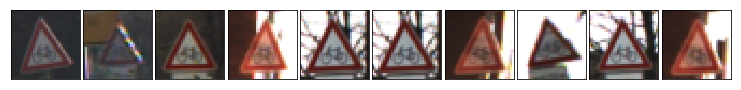

30 . Class :  Beware of ice/snow


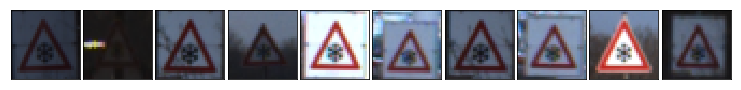

31 . Class :  Wild animals crossing


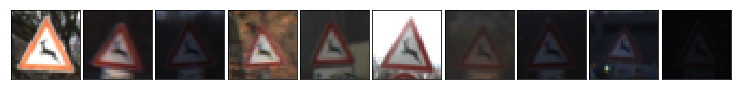

32 . Class :  End of all speed and passing limits


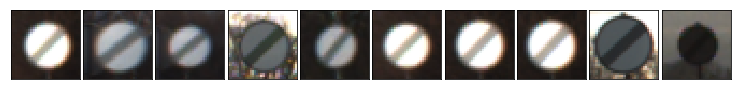

33 . Class :  Turn right ahead


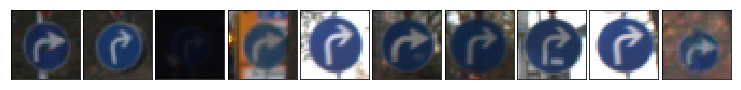

34 . Class :  Turn left ahead


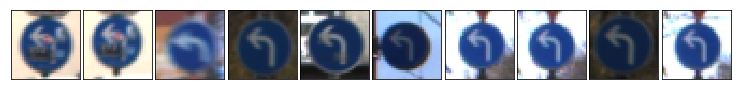

35 . Class :  Ahead only


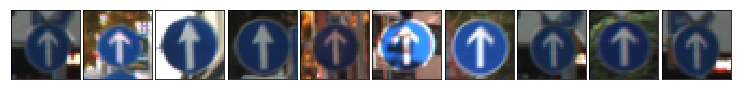

36 . Class :  Go straight or right


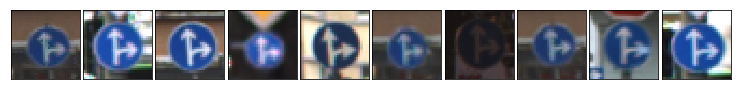

37 . Class :  Go straight or left


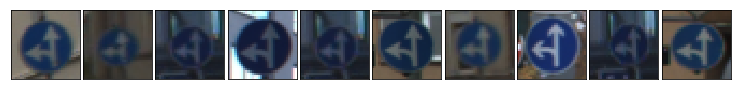

38 . Class :  Keep right


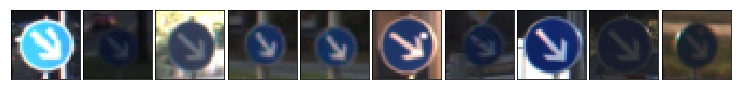

39 . Class :  Keep left


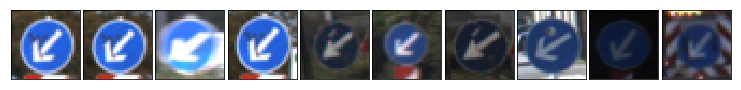

40 . Class :  Roundabout mandatory


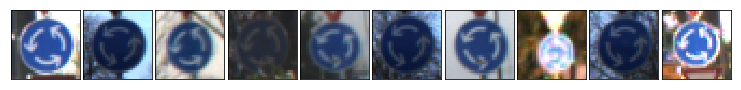

41 . Class :  End of no passing


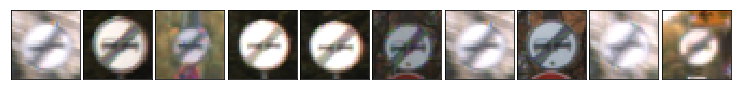

42 . Class :  End of no passing by vehicles over 3.5 metric tons


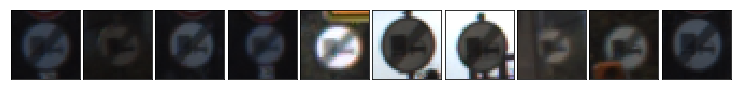

In [4]:

for c, c_i, c_count in zip(classes, class_indices, class_counts):
    print(c, ". Class : ", sign_names[c] )
    fig = pyplot.figure(figsize = (10, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        random_indices = np.random.randint(c_i, c_i+c_count, 10)
        axis.imshow(X_train[random_indices[i],:,:,:])
        #axis.text(0, 0, '{}: {}'.format(c, sign_names[c]), color='k',backgroundcolor='c', fontsize=8)
        
    pyplot.show()




### Breif Visual Overview of the Dataset

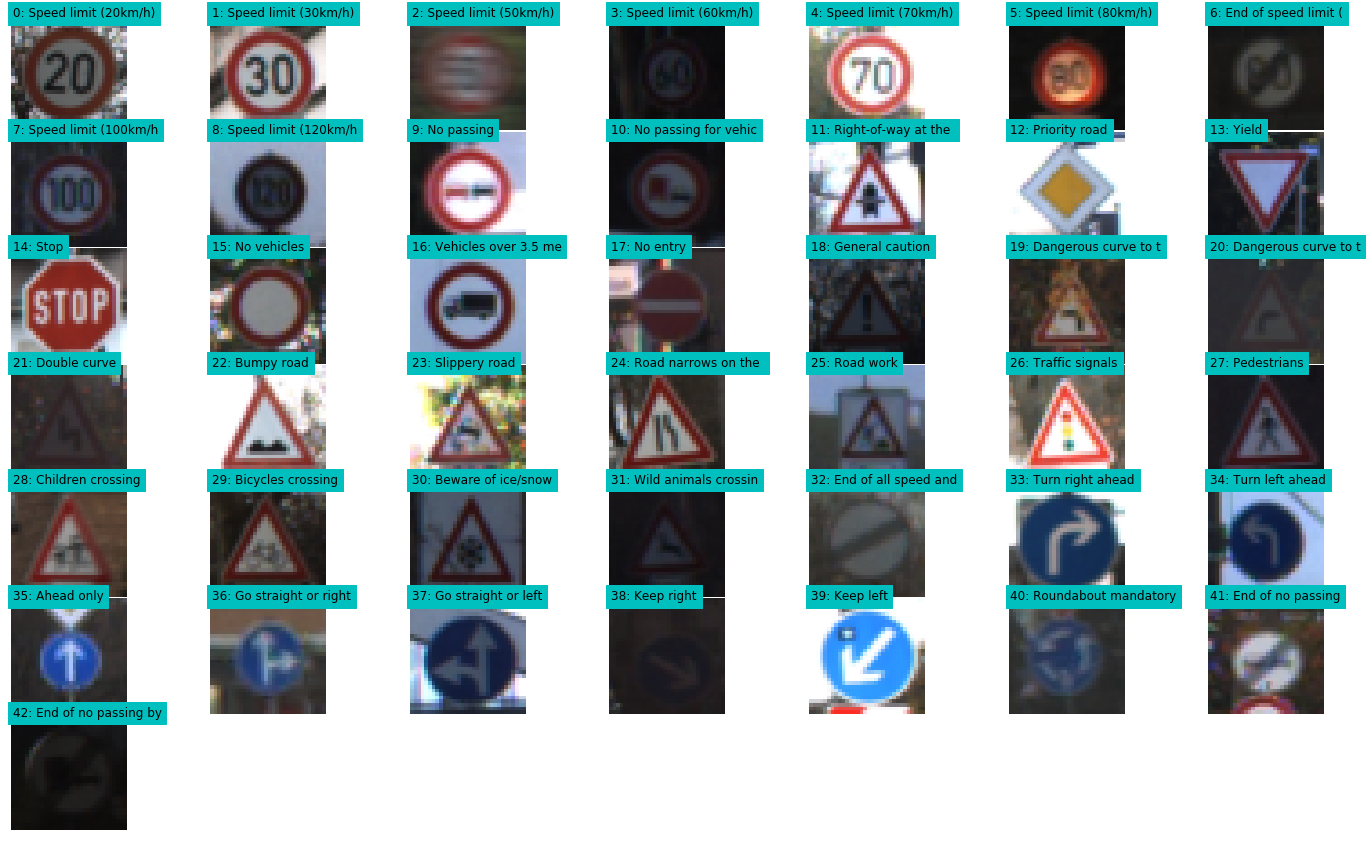

In [245]:
def plot_random_each_class(n_row,n_col,X,y):

    plt.figure(figsize = (25,15))
    gs1 = gridspec.GridSpec(n_row,n_row)
    gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes. 

    for c, c_i, c_count in zip(classes, class_indices, class_counts):
        # i = i + 1 # grid spec indexes from 0
        ax1 = plt.subplot(gs1[c])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        #plt.subplot(4,11,i+1)
        ind_plot = np.random.randint(c_i, c_i+c_count)
        plt.imshow(X[ind_plot])
        #plt.text(2,4,str(y[ind_plot]),color='k',backgroundcolor='c', fontsize=15)
        plt.text(0, 0, '{}: {:.20}'.format(c, sign_names[c]), color='k',backgroundcolor='c', fontsize=12)
        
        plt.axis('off')
    plt.show()

plot_random_each_class(7,7,X_train,y_train)

## T-SNE

--- 
## Data Augmentation


From exploring the data set of german traffic signs a few thing have become apprent.


The disturbution of classes over the data set is extreamly unblanced. This will cause a heavy amount of bias in the training process.

The amount of samples for the dataset is not sufficent to learn a model will a high generalisation and robustness to natural distortions present in operational settings. 

To resolve both these issues we must use class preserving data augmenetation straigies to produce more data, with distortions expected to be present in real data, such as rotations / translations and projections.

In [6]:
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import cv2

def rotate_image(image, max_angle =15):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

def translate_image(image, max_trans = 5, height=32, width=32):
    translate_x = max_trans*np.random.uniform() - max_trans/2
    translate_y = max_trans*np.random.uniform() - max_trans/2
    translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
    trans = cv2.warpAffine(image, translation_mat, (height,width))
    return trans
    
def projection_transform(image, max_warp=0.8, height=32, width=32):
    #Warp Location
    d = height * 0.3 * np.random.uniform(0,max_warp)
    
    #Warp co-ordinates
    tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
    tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
    tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
    br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin
        
    ##Apply Projection
    transform = ProjectiveTransform()
    transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, height - bl_bottom),
                (height - br_right, height - br_bottom),
                (height - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, height),
                (height, height),
                (height, 0)
            )))
    output_image = warp(image, transform, output_shape=(height, width), order = 1, mode = 'edge')
    return output_image
    

def transform_image(image, max_angle=15, max_trans =5 ,max_warp=0.8):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = rotate_image(image, max_angle)
    #Translate Image
    translated_image = translate_image(rotated_image, max_trans, height, width)
    #Project Image
    output_image = projection_transform(translated_image, max_warp, height, width)
    return (output_image*255.0).astype(np.uint8)

    
def augment_and_balance_data(X_train, y_train, no_examples_per_class =10000):
    
    n_examples = no_examples_per_class
    #Get paramters of data
    classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
    height, width, channels = X_train[0].shape
    
    
    #Create new data and labels for the balanced augmented data
    X_balance = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
    y_balance = np.empty([0], dtype = y_train.dtype)
    

    for c, count in zip(range(n_classes), class_counts):
        ##Copy over the current data for the given class
        X_orig = X_train[y_train == c]
        y_orig = y_train[y_train == c]
        ##Add original data to the new dataset
        X_balance = np.append(X_balance, X_orig, axis=0)
        print(c,count)
        temp_X = np.empty([n_examples-count, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
        for i in range(n_examples - count):
            temp_X[i,:,:,:] = transform_image(X_orig[i%count]).reshape((1, height, width, channels))
            
            
        X_balance = np.append(X_balance,temp_X, axis=0)
        n_added_ex = X_balance.shape[0] - y_balance.shape[0]
        y_balance = np.append(y_balance, np.full(n_added_ex, c, dtype =int))
        
   
    return X_balance.astype(np.uint8), y_balance
        
    

### Example of Rotation

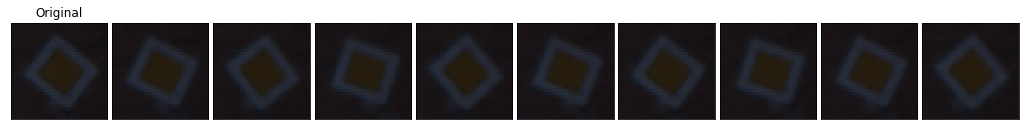

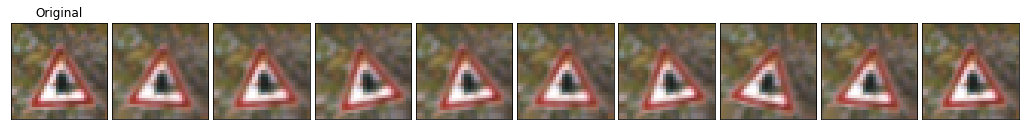

In [7]:
no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train[image[j],:,:,:])
            axis.title.set_text('Original')
        else:    
            axis.imshow(rotate_image(X_train[image[j],:,:,:], 20))
    pyplot.show()

### Example of Translation

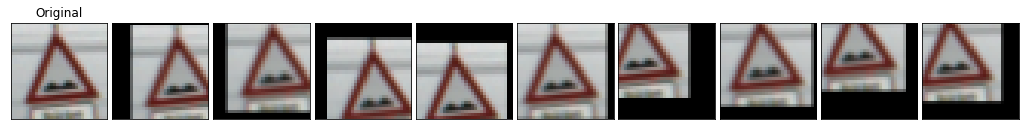

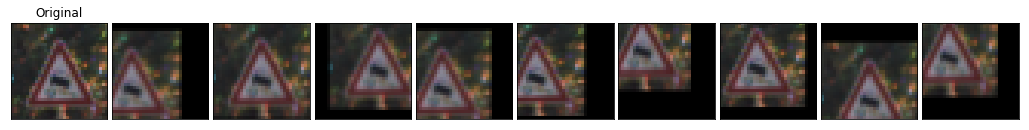

In [8]:
no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train[image[j],:,:,:])
            axis.title.set_text('Original')
        else:    
            axis.imshow(translate_image(X_train[image[j],:,:,:], 20))
    pyplot.show()

### Example of Homography Projection

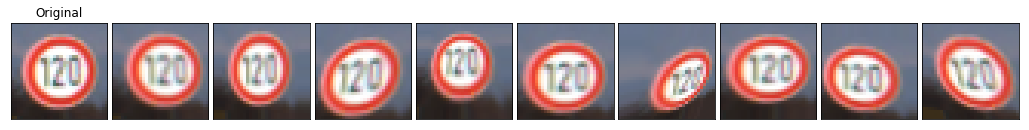

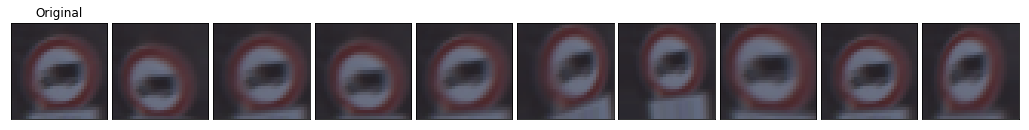

In [9]:
no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train[image[j],:,:,:])
            axis.title.set_text('Original')
        else:    
            axis.imshow(projection_transform(X_train[image[j],:,:,:]))
    pyplot.show()

### Example of Data Augmentation Pipeline

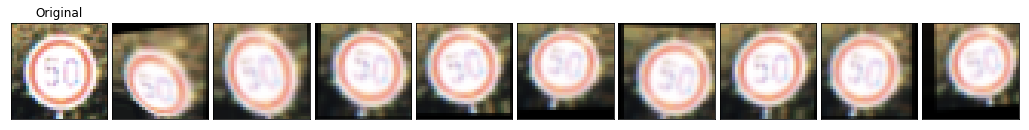

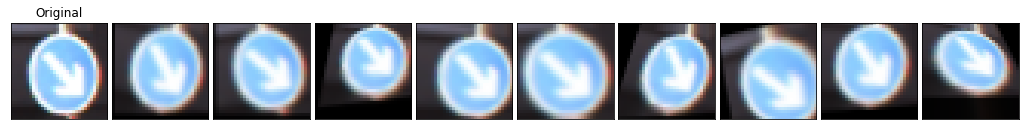

In [10]:
no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train[image[j],:,:,:])
            axis.title.set_text('Original')
        else:    
            axis.imshow(transform_image(X_train[image[j],:,:,:]))
    pyplot.show()

### Generate or Load Augmented Dataset

In [ ]:
####Only Run to generate Augmented data !!!!! (is LONG)
## Resulting saved data set will be around 1GB for 10000 examples each class

#X_out, y_out = augment_and_balance_data(X_train, y_train, 10000)
#np.savez_compressed('Dataset/Augmented_Data/AugTrafficdata', X_train_aug = X_out, y_train_aug = y_out)

In [294]:
##Load premade augmented data

loaded = np.load('Dataset/Augmented_Data/AugTrafficdata.npz')
X_train_aug = loaded['X_train_aug']
y_train_aug = loaded['y_train_aug']
print("Augmented Dataset size X")
print(X_train_aug.shape)
print("Augmented Dataset size y")
print(y_train_aug.shape)


Augmented Dataset size X
(430000, 32, 32, 3)
Augmented Dataset size y
(430000,)


---
## Deep Classification Architectures

We now need to build, and train some deep architectures capable of accuratly classifying traffic signs of the type seen in this data set. These model will be trained on the augmented data set

I considered two convolutional neural network architectures

AlexNet (2012)(CIFAR10 Style) :  Classic architecture with additional Batch Normalisation layers to assist training

DenseNet (2016) : Current SOTA for IMAGE classification (CIFAR, IMAGENET etc)



### Tensorflow Utility Functions

In [12]:
import tensorflow as tf
import numpy as np

def new_fc_layer( bottom, output_size, name, regularizer =None):
    shape = bottom.get_shape().as_list()
    dim = np.prod( shape[1:] )
    x = tf.reshape( bottom, [-1, dim])
    input_size = dim

    with tf.variable_scope(name):
        w = tf.get_variable(
                "W",
                shape=[input_size, output_size],
                initializer=tf.random_normal_initializer(0., 0.005), regularizer=regularizer)
        b = tf.get_variable(
                "b",
                shape=[output_size],
                initializer=tf.constant_initializer(0.))
        fc = tf.nn.bias_add( tf.matmul(x, w), b)
        tf.summary.histogram(name + '_W', w)
        tf.summary.histogram(name + '_b', b)

    return fc


def new_conv_layer( bottom, filter_shape, activation=tf.identity, padding='SAME', stride=1, name=None, regularizer = None ):
    with tf.variable_scope( name):
        w = tf.get_variable(
                "W",
                shape=filter_shape,
                initializer=tf.random_normal_initializer(0., 0.005), regularizer=regularizer)
        b = tf.get_variable(
                "b",
                shape=filter_shape[-1],
                initializer=tf.constant_initializer(0.))

        conv = tf.nn.conv2d( bottom, w, [1,stride,stride,1], padding=padding)
        bias = activation(tf.nn.bias_add(conv, b))
        tf.summary.histogram(name + '_W', w)
        tf.summary.histogram(name + '_b', b)

    return bias

def channel_wise_fc_layer( input, name, regularizer = None): # bottom: (7x7x512)
    _, width, height, n_feat_map = input.get_shape().as_list()
    input_reshape = tf.reshape( input, [-1, width*height, n_feat_map] )
    input_transpose = tf.transpose( input_reshape, [2,0,1] )

    with tf.variable_scope(name):
        W = tf.get_variable(
                "W",
                shape=[n_feat_map,width*height, width*height], # (512,49,49)
                initializer=tf.random_normal_initializer(0., 0.005))
        output = tf.batch_matmul(input_transpose, W)
        tf.summary.histogram(name + '_W', W)

    output_transpose = tf.transpose(output, [1,2,0])
    output_reshape = tf.reshape( output_transpose, [-1, height, width, n_feat_map] )


    return output_reshape



def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)



def conv2d(input, in_features, out_features, kernel_size, with_bias=False):
    W = weight_variable([ kernel_size, kernel_size, in_features, out_features ])
    conv = tf.nn.conv2d(input, W, [ 1, 1, 1, 1 ], padding='SAME')
    if with_bias:
        return conv + bias_variable([ out_features ])
    return conv


def batch_activ_conv(current, in_features, out_features, kernel_size, is_training, keep_prob):
    current = tf.contrib.layers.batch_norm(current, scale=True, is_training=is_training, updates_collections=None)
    current = tf.nn.relu(current)
    current = conv2d(current, in_features, out_features, kernel_size)
    current = tf.nn.dropout(current, keep_prob)
    return current

def block(input, layers, in_features, growth, is_training, keep_prob):
    current = input
    features = in_features
    for idx in range(layers):
        tmp = batch_activ_conv(current, features, growth, 3, is_training, keep_prob)
        current = tf.concat( [current, tmp], 3)
        features += growth
    return current, features




def avg_pool(input, s):
    return tf.nn.avg_pool(input, [ 1, s, s, 1 ], [1, s, s, 1 ], 'VALID')

def batch_norm(input, is_train):
    return tf.contrib.layers.batch_norm(input, scale=True, is_training=is_train, updates_collections=None)
    

### AlexNet Style Architecture (With additional batch Norm)

In [13]:
def AlexNet(X, y, keep_prob, is_train, regularizer = None):
    #First Convolutional Layer
        conv1 = new_conv_layer(X, [5,5,3,64], stride=1, name='conv1', regularizer=regularizer)
        bn1 = batch_norm(conv1, is_train)
        relu1 = tf.nn.relu(bn1)
        pool1 = tf.nn.max_pool(relu1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME', name='pool1')

        #Second Convolutional Layer
        conv2 = new_conv_layer(pool1, [5,5,64,64], stride=1, name='conv2',regularizer=regularizer)
        bn2 = batch_norm(conv2, is_train)
        relu2 = tf.nn.relu(bn2)
        pool2 = tf.nn.max_pool(relu2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME', name='pool2')

        #First fully connected layer
        fc_1 = new_fc_layer(pool2, 384, name='Fully_connected_1',regularizer=regularizer)
        bn3 = batch_norm(fc_1, is_train)
        relu3 = tf.nn.relu(bn3)
        h_fc1_drop = tf.nn.dropout(relu3, keep_prob)

        #Second fully connected layer
        fc_2 = new_fc_layer(h_fc1_drop,192, name = 'Fully_connected_2', regularizer=regularizer)
        bn4 = batch_norm(fc_2, is_train)
        relu4 = tf.nn.relu(bn4)

        h_fc2_drop = tf.nn.dropout(relu4, keep_prob)

        #Output logits
        logits = new_fc_layer(h_fc2_drop, 43, name = 'Output_Logits', regularizer=regularizer)

        return logits
    

### DenseNet Architecture (no BC)

In [14]:
##DenseNet Architecture, based on the offical recommeneded implementation
## https://github.com/LaurentMazare/deep-models/blob/master/densenet/densenet.py
def DenseNet(X, y , keep_prob, is_train, depth=40):
    
    layers = int((depth-4) / 3)
    
    #Inital convolution
    current = conv2d(X, 3, 16, 3)
    
    #First DenseBlock
    current, features = block(current, layers, 16, 12, is_train, keep_prob)
    
    current = batch_activ_conv(current, features, features, 1, is_train, keep_prob)
    current = avg_pool(current, 2)
    
    #Second DenseBlock
    current, features = block(current, layers, features, 12, is_train, keep_prob)
    
    current = batch_activ_conv(current, features, features, 1, is_train, keep_prob)
    current = avg_pool(current, 2)
    
    #Third DenseBlock
    current, features = block(current, layers, features, 12, is_train, keep_prob)

    current = tf.contrib.layers.batch_norm(current, scale=True, is_training=is_train, updates_collections=None)
    current = tf.nn.relu(current)
    current = avg_pool(current, 8)
    final_dim = features
    current = tf.reshape(current, [ -1, final_dim ])
    Wfc = weight_variable([ final_dim, 43 ])
    bfc = bias_variable([ 43 ])
    logits = tf.matmul(current, Wfc) + bfc 
    
    return logits
    
    
    

### Preprocess Data

In [295]:
import cv2

def image_brightness_normalisation(image):
    image[:,:,0] = cv2.equalizeHist(image[:,:,0])
    image[:,:,1] = cv2.equalizeHist(image[:,:,1])
    image[:,:,2] = cv2.equalizeHist(image[:,:,2])
    return image

def preprocess_data_1(X):
    #Remove the mean of data across each channel
    #X = X - np.mean(X_train.mean(axis=(1,2)), axis=0)
    X = X - np.mean(X, axis=0)
    
    X /= np.std(X, axis=0)
    return X
    
def preprocess_data_2(X):

    for i in range(len(X)):
        X[i,:,:,:] = image_brightness_normalisation(X[i,:,:,:])
    X = X/255.0 - 0.5
    return X
    
        
    
X_train = preprocess_data_2(X_train)
X_test = preprocess_data_2(X_test)
X_valid = preprocess_data_2(X_valid)
X_train_aug = preprocess_data_2(X_train_aug)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(X_train_aug.shape)


(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)
(430000, 32, 32, 3)


---
## Train, The Model

In [16]:
from sklearn.utils import shuffle
import os
def get_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

#############################
#   MODEL TRAINING PARAMETERS
##############################

#Dataset parameters
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_CHANNELS = 3
NO_CLASSES = 43



EPOCHS = 100
BATCH_SIZE = 64

##Alex Net Model Hyper parameters
LEARNING_RATE_A = 0.00005
WEIGHT_DECAY_A = 0
KEEP_PROB_A = 0.8

#DenseNet Model Hyper Parameters
LEARNING_RATE_D = 0.01
WEIGHT_DECAY_D = 0
KEEP_PROB_D = 0.9

#Training output paramters
STATS_FREQ = 100
SUMMARY_FREQ = 100
MODEL_SAVE_FREQ = 1

##Model parameters and saving dir
SAVE_NAME = 'DenseNet_Augmentation/'
SAVE_DIR = get_dir('SAVE/')
MODEL_SAVE_DIR = get_dir(SAVE_DIR + 'Models/' + SAVE_NAME)
SUMMARY_SAVE_DIR = get_dir(SAVE_DIR + 'Summaries/' + SAVE_NAME)

#MODEL_LOAD_PATH = None
MODEL_LOAD_PATH = './' + MODEL_SAVE_DIR + 'model.ckpt-54'


model = 'DenseNet'


##Note: Best alexNet Model
##   AlexNet_Augmentation2/    save 90 (98.32%)

In [87]:
#Helper class to train AlexNet

class AlexNetRunner:
    def __init__(self, session, summary_writer, learning_rate=0.001, weight_decay=5e-4, keep_prob = 0.6):

        self.sess = session
        self.summary_writer = summary_writer
        self.learning_rate_init = learning_rate
        self.weight_decay = weight_decay
        self.input_keep_prob = keep_prob
        self.define_graph()

    def training_step(self, batch_X, batch_y):

        feed_dict = {self.input_image : batch_X, self.y : batch_y, self.keep_prob: self.input_keep_prob ,self.is_train : True, self.learning_rate : self.learning_rate_init}

        _, loss, global_step, sum1 = self.sess.run([self.train_step, self.mean_loss,  self.global_step, self.summaries], feed_dict=feed_dict)

        if global_step % STATS_FREQ ==0:
            train_accuracy = self.sess.run(self.accuracy_operation, feed_dict= {self.input_image : batch_X, self.y : batch_y, self.keep_prob :1.0, self.is_train :False})
            print("Iteration ", global_step, ": with training loss = ", loss, " and accuracy of " , train_accuracy)

        if global_step % SUMMARY_FREQ == 0:
            self.summary_writer.add_summary(sum1, global_step)
            
        
    def define_graph(self):

        print("Initalising traffic sign classification model")
        #Define the inputs for the model
        with tf.name_scope('Inputs'):
            self.input_image = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], name='Input_X')
            self.y = tf.placeholder(tf.int32, (None), name ='Input_y')
            self.one_hot_y = tf.one_hot(self.y, NO_CLASSES)
            self.is_train = tf.placeholder(tf.bool)
            self.keep_prob = tf.placeholder(tf.float32)
            self.k = tf.placeholder(tf.int32)
            #self.learning_rate = tf.placeholder(tf.float32)
            if self.weight_decay == 0:
                self.regularizer = None
            else:
                self.regularizer = tf.contrib.layers.l2_regularizer(self.weight_decay)

        ##Run batch through model to get logits
        self.y_out = AlexNet(self.input_image, self.one_hot_y, self.keep_prob ,self.is_train, self.regularizer)


        #Calculate the losses
        with tf.name_scope('Train'):
            self.reg_term = 0
            if self.regularizer is not None:
                self.reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
                self.reg_term = tf.contrib.layers.apply_regularization(self.regularizer, self.reg_variables)
            self.total_loss = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y , logits=self.y_out)
            self.mean_loss = tf.reduce_mean(self.total_loss)
            self.loss = self.mean_loss + self.reg_term
            
            self.probs = tf.nn.softmax(self.y_out)
            self.top_probs = tf.nn.top_k(self.probs, self.k)
           

            self.correct_prediction = tf.equal(tf.argmax(self.y_out, 1), tf.argmax( self.one_hot_y,1))
            self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

            ##Add the losses to summaries
            self.sum1 = tf.summary.scalar('Average_cross_entropy_loss', self.mean_loss)
            self.sum2 = tf.summary.scalar('Train_Accuracy', self.accuracy_operation)

    

        with tf.name_scope('Optimiser'):
            self.global_step = tf.Variable(0, trainable=False, name='global_step')
            #Simple decay every 100000 with a base of 0.96
            self.learning_rate = tf.train.exponential_decay(self.learning_rate_init, self.global_step, 50000, 0.8, staircase=True)
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate_init)
            #self.optimizer = tf.train.MomentumOptimizer(self.learning_rate, 0.9, use_nesterov=True)
            ##Following two lines required to update the moveing average parameters
            ##In batch norm layers
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(extra_update_ops):
                self.train_step = self.optimizer.minimize(self.loss, global_step = self.global_step)


        self.summaries = tf.summary.merge_all()

        self.validation_acc_summary = tf.summary.scalar('Validation_accuracy', self.accuracy_operation)



    def evaluate(self, X, y, max_batch = 128):
        num_examples = len(X)
        total_acc = 0 
        total_loss =0
        
        for offset in range(0, num_examples, max_batch):
            batch_X , batch_y = X[offset:offset + max_batch], y[offset: offset + max_batch]
            feed_dict = {self.input_image : batch_X, self.y : batch_y, self.is_train : False, self.keep_prob: 1.0}
            accuracy, loss = self.sess.run([self.accuracy_operation, self.mean_loss ], feed_dict= feed_dict)
            total_acc += (accuracy * len(batch_X))
            total_loss += (loss * len(batch_X))
        return total_acc / num_examples, total_loss / num_examples
    
    def classify_images(self, X, top_k =5):
        num_images = len(X)
        feed_dict = {self.input_image : X, self.is_train : False, self.keep_prob: 1.0, self.k : top_k}
        probs = self.sess.run(self.top_probs, feed_dict= feed_dict)
        return probs

    


In [100]:
class DenseNetRunner:
    def __init__(self, session, summary_writer, learning_rate=0.1, weight_decay=0.0001, keep_prob = 0.8):

        self.sess = session
        self.summary_writer = summary_writer
        self.learning_rate_init = learning_rate
        self.weight_decay = weight_decay
        self.input_keep_prob = keep_prob
        self.define_graph()

    def training_step(self, batch_X, batch_y):

        feed_dict = {self.input_image : batch_X, self.y : batch_y, self.keep_prob: self.input_keep_prob ,self.is_train : True, self.learning_rate : self.learning_rate_init}

        _, loss, global_step, sum1 = self.sess.run([self.train_step, self.mean_loss,  self.global_step, self.summaries], feed_dict=feed_dict)

        if global_step % STATS_FREQ ==0:
            train_accuracy = self.sess.run(self.accuracy_operation, feed_dict= {self.input_image : batch_X, self.y : batch_y, self.keep_prob :1.0, self.is_train :False})
            print("Iteration ", global_step, ": with training loss = ", loss, " and accuracy of " , train_accuracy)

        if global_step % SUMMARY_FREQ == 0:
            self.summary_writer.add_summary(sum1, global_step)
            
        ##Code to change the learning rate with the number or epochs needed

    def define_graph(self):

        print("Initalising traffic sign classification model")
        #Define the inputs for the model
        with tf.name_scope('Inputs'):
            self.input_image = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], name='Input_X')
            self.y = tf.placeholder(tf.int32, (None), name ='Input_y')
            self.one_hot_y = tf.one_hot(self.y, NO_CLASSES)
            self.is_train = tf.placeholder(tf.bool)
            self.keep_prob = tf.placeholder(tf.float32)
            self.learning_rate = tf.placeholder(tf.float32)
            self.k = tf.placeholder(tf.int32)
            

        ##Run batch through model to get logits
        self.y_out = DenseNet(self.input_image, self.one_hot_y, self.keep_prob ,self.is_train)


        #Calculate the losses
        with tf.name_scope('Train'):
            
            self.l2 = tf.add_n([tf.nn.l2_loss(var) for var in tf.trainable_variables()])
            self.total_loss = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y , logits=self.y_out)
            self.mean_loss = tf.reduce_mean(self.total_loss)
            self.loss = self.mean_loss + self.l2*self.weight_decay
           
            self.correct_prediction = tf.equal(tf.argmax(self.y_out, 1), tf.argmax( self.one_hot_y,1))
            self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

            self.probs = tf.nn.softmax(self.y_out)
            self.top_probs = tf.nn.top_k(self.probs, self.k)
            
            ##Add the losses to summaries
            self.sum1 = tf.summary.scalar('Average_cross_entropy_loss', self.mean_loss)
            self.sum2 = tf.summary.scalar('Train_Accuracy', self.accuracy_operation)

    

        with tf.name_scope('Optimiser'):
            self.global_step = tf.Variable(0, trainable=False, name='global_step')
            self.optimizer = tf.train.MomentumOptimizer(self.learning_rate, 0.9, use_nesterov=True)
            self.train_step = self.optimizer.minimize(self.loss, global_step = self.global_step)


        self.summaries = tf.summary.merge_all()
        self.validation_acc_summary = tf.summary.scalar('Validation_accuracy', self.accuracy_operation)



    def evaluate(self, X, y, max_batch = 128):
        num_examples = len(X)
        total_acc = 0 
        total_loss =0
        
        for offset in range(0, num_examples, max_batch):
            batch_X , batch_y = X[offset:offset + max_batch], y[offset: offset + max_batch]
            feed_dict = {self.input_image : batch_X, self.y : batch_y, self.is_train : False, self.keep_prob: 1.0}
            accuracy, loss = self.sess.run([self.accuracy_operation, self.mean_loss ], feed_dict= feed_dict)
            total_acc += (accuracy * len(batch_X))
            total_loss += (loss * len(batch_X))
        return total_acc / num_examples, total_loss / num_examples
    
    def classify_images(self, X, top_k =5):
        num_images = len(X)
        feed_dict = {self.input_image : X, self.is_train : False, self.keep_prob: 1.0, self.k : top_k}
        probs = self.sess.run(self.top_probs, feed_dict= feed_dict)
        return probs


    


## Train Network

In [ ]:

if MODEL_LOAD_PATH is not None:
    loaded = np.load(MODEL_SAVE_DIR + 'trainingdata.npz')
    valid_hist_acc = loaded['valid_hist_acc'].tolist()
    train_hist_acc = loaded['train_hist_acc'].tolist()
    valid_hist_loss = loaded['valid_hist_loss'].tolist()
    train_hist_loss = loaded['train_hist_loss'].tolist()
else:
    valid_hist_acc = []
    train_hist_acc = []
    valid_hist_loss = []
    train_hist_loss = []
      



def plot_training(train_hist_in, valid_hist_in):
    curves_figure = pyplot.figure(figsize = (10, 4))
    axis = curves_figure.add_subplot(1,2,1)
    axis.plot(train_hist_in, label='train')
    axis.plot(valid_hist_in, label='valid')
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("accuracy")
    
    axis = curves_figure.add_subplot(1,2,1)
    axis.plot(train_hist_in, label='train')
    axis.plot(valid_hist_in, label='valid')
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("accuracy")

tf.reset_default_graph()

with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(SUMMARY_SAVE_DIR, graph= sess.graph)
    if model == 'AlexNet':
        print('AlexNet Model')
        TrafficNet = AlexNetRunner(sess, summary_writer, LEARNING_RATE_A, WEIGHT_DECAY_A, KEEP_PROB_A )
    elif model == 'DenseNet':
        print('DenseNet Model')
        TrafficNet = DenseNetRunner(sess, summary_writer, LEARNING_RATE_D, WEIGHT_DECAY_D, KEEP_PROB_D)
    else:
        print('Not a valid Model')
        
    Saver = tf.train.Saver(max_to_keep=100)
    sess.run(tf.global_variables_initializer())
    
    if MODEL_LOAD_PATH is not None:
        Saver.restore(sess, MODEL_LOAD_PATH)
        print('Model restored from ' + MODEL_LOAD_PATH)
        
    num_examples = len(X_train_aug)
    print("Training...")
    print()
    for i in range(len(valid_hist_acc), EPOCHS):
        X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_aug[offset:end], y_train_aug[offset:end]
            TrafficNet.training_step(batch_x, batch_y)
            
        validation_accuracy, valid_loss = TrafficNet.evaluate(X_valid, y_valid, max_batch = BATCH_SIZE)
        training_accuracy, training_loss = TrafficNet.evaluate(X_train, y_train, max_batch = BATCH_SIZE)
        valid_hist_acc.append(validation_accuracy)
        train_hist_acc.append(training_accuracy)
        valid_hist_loss.append(valid_loss)
        train_hist_loss.append(training_loss)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        
        #plot_training(train_hist, valid_hist)
        if i % MODEL_SAVE_FREQ ==0:
            print('Saving model ...')
            Saver.save(sess, MODEL_SAVE_DIR + 'model.ckpt', global_step=i)
            np.savez_compressed(MODEL_SAVE_DIR + 'trainingdata', train_hist_acc = train_hist_acc, valid_hist_acc = valid_hist_acc, train_hist_loss =train_hist_loss, valid_hist_loss=valid_hist_loss)
    


## Visualise Training

In [ ]:
def plot_training(train_hist_acc_in, valid_hist_acc_in, train_hist_loss_in, valid_hist_loss_in):
    curves_figure = pyplot.figure(figsize = (10, 4))
    axis = curves_figure.add_subplot(1,2,1)
    axis.plot(train_hist_acc_in, label='train')
    axis.plot(valid_hist_acc_in, label='valid')
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("accuracy")
    
    axis = curves_figure.add_subplot(1,2,2)
    axis.plot(train_hist_loss_in, label='train')
    axis.plot(valid_hist_loss_in, label='valid')
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("cross-entropy")



plot_training( train_hist_acc, valid_hist_acc,  train_hist_loss, valid_hist_loss )
#np.savez_compressed(MODEL_SAVE_DIR + 'trainingdata', train_hist_acc = train_hist_acc, valid_hist_acc = valid_hist_acc, train_hist_loss =train_hist_loss, valid_hist_loss=valid_hist_loss  )

## Test Best AlexNet Model

In [299]:
SAVE_NAME = 'AlexNet_Augmentation2/'
SAVE_DIR = get_dir('SAVE/')
MODEL_SAVE_DIR = get_dir(SAVE_DIR + 'Models/' + SAVE_NAME)
MODEL_LOAD_PATH = './' + MODEL_SAVE_DIR + 'model.ckpt-90'

tf.reset_default_graph()

with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(SUMMARY_SAVE_DIR, graph= sess.graph)
    TrafficNet = AlexNetRunner(sess, summary_writer, LEARNING_RATE_A, WEIGHT_DECAY_A, KEEP_PROB_A)
    Saver = tf.train.Saver(max_to_keep=100)
    sess.run(tf.global_variables_initializer())
    if MODEL_LOAD_PATH is not None:
        Saver.restore(sess, MODEL_LOAD_PATH)
        print('Model restored from ' + MODEL_LOAD_PATH)
        acc, loss = TrafficNet.evaluate(X_test, y_test, max_batch = BATCH_SIZE)
        print("Final AlexNet accuracy on the test set ", acc*100, "%")
tf.reset_default_graph()

Initalising traffic sign classification model
INFO:tensorflow:Restoring parameters from ./SAVE/Models/AlexNet_Augmentation2/model.ckpt-90
Model restored from ./SAVE/Models/AlexNet_Augmentation2/model.ckpt-90
Final AlexNet accuracy on the test set  98.329374507 %


## Test Best DenseNet

In [20]:
SAVE_NAME = 'DenseNet_Augmentation/'
SAVE_DIR = get_dir('SAVE/')
MODEL_SAVE_DIR = get_dir(SAVE_DIR + 'Models/' + SAVE_NAME)
MODEL_LOAD_PATH = './' + MODEL_SAVE_DIR + 'model.ckpt-54'


tf.reset_default_graph()

with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(SUMMARY_SAVE_DIR, graph= sess.graph)
    TrafficNet = DenseNetRunner(sess, summary_writer, LEARNING_RATE_A, WEIGHT_DECAY_A, KEEP_PROB_A)
    Saver = tf.train.Saver(max_to_keep=100)
    sess.run(tf.global_variables_initializer())
    if MODEL_LOAD_PATH is not None:
        Saver.restore(sess, MODEL_LOAD_PATH)
        print('Model restored from ' + MODEL_LOAD_PATH)
        acc, loss = TrafficNet.evaluate(X_test, y_test, max_batch = BATCH_SIZE)
        
        print("Final DenseNet accuracy on the test set ", acc*100, "%")
tf.reset_default_graph()

Initalising traffic sign classification model
INFO:tensorflow:Restoring parameters from ./SAVE/Models/DenseNet_Augmentation/model.ckpt-54
Model restored from ./SAVE/Models/DenseNet_Augmentation/model.ckpt-54
Final DenseNet accuracy on the test set  99.0182106097 %


***
# Run Models on images from web

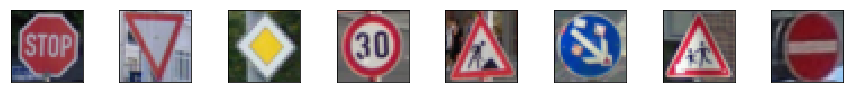

In [260]:
## Load the new images into an array and resize to correct dimensions

import matplotlib.image as mpimg
import scipy

no_images = 8
new_images_original = []
new_images = []

for i in range(no_images):
    image = mpimg.imread('Example_Traffic_Signs/Sign' + str(i+1) +'.png')
    new_images_original.append(image)
    y = scipy.misc.imresize(image, (32,32), interp='bilinear')
    new_images.append(y)
new_images = np.asarray(new_images)


fig = pyplot.figure(figsize = (12, 1))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
for i in range(no_images):
    axis = fig.add_subplot(1, no_images, i + 1, xticks=[], yticks=[])
    axis.imshow(new_images[i,:,:,:])
       
pyplot.show()

##Preprocess the images
new_images = preprocess_data_2(new_images)



## Manually Label New Data

In [261]:
y_new_images = np.zeros((no_images,), dtype=np.int)

y_new_images[0] = 14
y_new_images[1] = 13
y_new_images[2] = 12
y_new_images[3] = 1
y_new_images[4] = 25
y_new_images[5] = 38
y_new_images[6] = 28
y_new_images[7] = 17

## Test Images on AlexNet

In [256]:
SAVE_NAME = 'AlexNet_Augmentation2/'
SAVE_DIR = get_dir('SAVE/')
MODEL_SAVE_DIR = get_dir(SAVE_DIR + 'Models/' + SAVE_NAME)
MODEL_LOAD_PATH = './' + MODEL_SAVE_DIR + 'model.ckpt-90'

tf.reset_default_graph()

with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(SUMMARY_SAVE_DIR, graph= sess.graph)
    TrafficNet = AlexNetRunner(sess, summary_writer, LEARNING_RATE_A, WEIGHT_DECAY_A, KEEP_PROB_A)
    Saver = tf.train.Saver(max_to_keep=100)
    sess.run(tf.global_variables_initializer())
    if MODEL_LOAD_PATH is not None:
        Saver.restore(sess, MODEL_LOAD_PATH)
        print('Model restored from ' + MODEL_LOAD_PATH)
        values_alex, indices_alex = TrafficNet.classify_images(new_images)
        
tf.reset_default_graph()

Initalising traffic sign classification model
INFO:tensorflow:Restoring parameters from ./SAVE/Models/AlexNet_Augmentation2/model.ckpt-90
Model restored from ./SAVE/Models/AlexNet_Augmentation2/model.ckpt-90


## Test Images on DenseNet

In [258]:
SAVE_NAME = 'DenseNet_Augmentation/'
SAVE_DIR = get_dir('SAVE/')
MODEL_SAVE_DIR = get_dir(SAVE_DIR + 'Models/' + SAVE_NAME)
MODEL_LOAD_PATH = './' + MODEL_SAVE_DIR + 'model.ckpt-54'

tf.reset_default_graph()

with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter(SUMMARY_SAVE_DIR, graph= sess.graph)
    TrafficNet = DenseNetRunner(sess, summary_writer, LEARNING_RATE_A, WEIGHT_DECAY_A, KEEP_PROB_A)
    Saver = tf.train.Saver(max_to_keep=100)
    sess.run(tf.global_variables_initializer())
    if MODEL_LOAD_PATH is not None:
        Saver.restore(sess, MODEL_LOAD_PATH)
        print('Model restored from ' + MODEL_LOAD_PATH)
        values_dense, indices_dense = TrafficNet.classify_images(new_images)
tf.reset_default_graph()

Initalising traffic sign classification model
INFO:tensorflow:Restoring parameters from ./SAVE/Models/DenseNet_Augmentation/model.ckpt-54
Model restored from ./SAVE/Models/DenseNet_Augmentation/model.ckpt-54


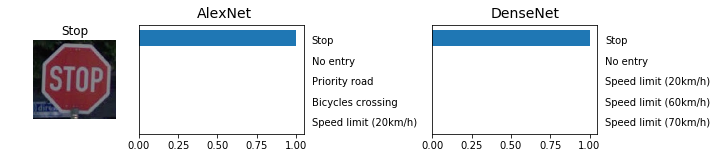

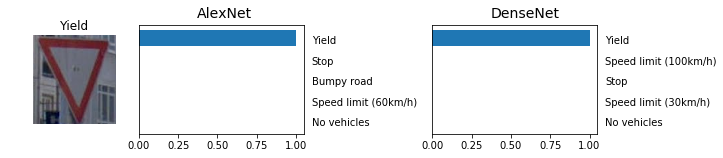

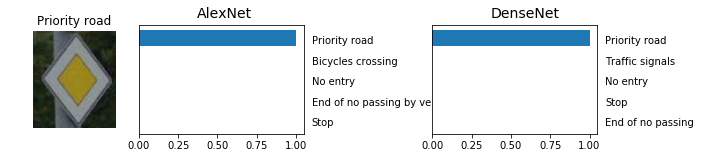

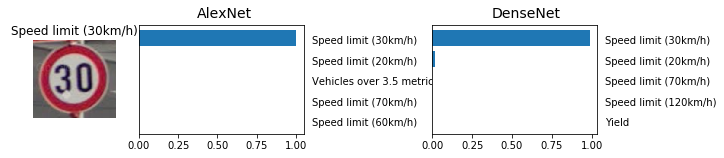

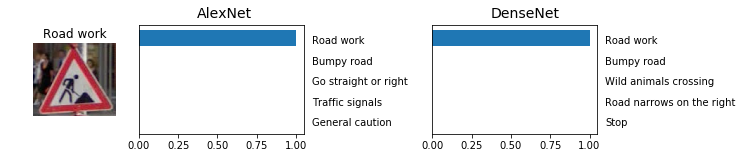

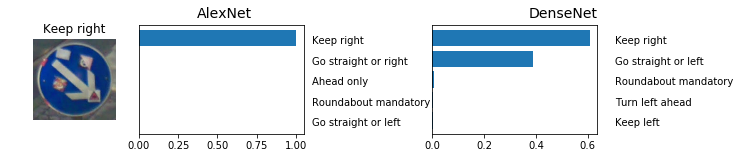

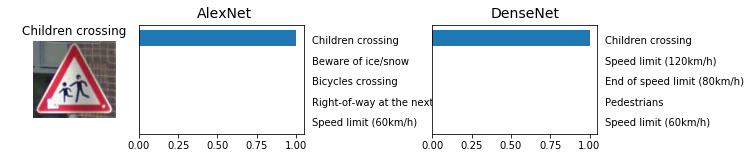

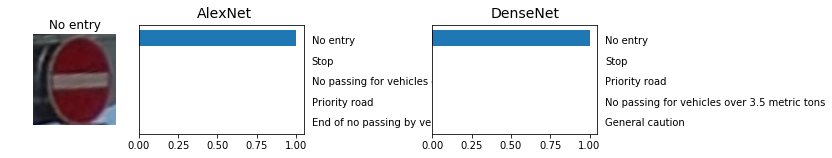

In [290]:
no_examples = no_images

for j in range(no_examples):
    plt.figure(figsize = (12,2))
    grid = gridspec.GridSpec(1,5, width_ratios=[2,4,2,4,2])
    fig = plt.subplot(grid[0])
    fig.imshow(new_images_original[j])
    #fig.text(0,0,sign_names[y_new_images[j]], fontsize=15)
    plt.title(sign_names[y_new_images[j]])
    fig.axis('off')

    fig = plt.subplot(grid[1])
    fig.yaxis.set_visible(False)
    fig.barh(6-np.arange(5), values_alex[j], align='center')
    fig.text(0.37,7, 'AlexNet', fontsize=14)
    for i in range(5):
        fig.text(values_alex[j,0]+ 0.10, 5.75-i, sign_names[indices_alex[j,i]])
    
    fig = plt.subplot(grid[3])
    fig.yaxis.set_visible(False)
    fig.barh(6-np.arange(5), values_dense[j], align='center')
    fig.text(0.37,7, 'DenseNet', fontsize=14)
    for i in range(5):
        fig.text(values_dense[j,0]+0.1, 5.75-i, sign_names[indices_dense[j,i]])
    
    


